Classification sur la variable "Satisfaction" :
1. Compléter l'analyse exploratoire de la question 1 en se focalisant sur les relations des différentes variables avec la variable cible.

2.  Prétraiter les données : choisir les variables explicatives (essayer plusieurs sélections), procéder à l'imputation des valeurs manquantes (tester plusieurs stratégies), normaliser les variables, etc.

3.  Appliquer les différents algorithmes étudiés en cours. Pour chacun d'eux on procèdera ainsi : définition d'un dictionnaire d'hyperparamètres, recherche exhaustive (ou aléatoire) des meilleurs hyperparamètres, établissement de la matrice de confusion, calculs des différentes métriques (exactitude, précision, rappel, F1 score, auc, etc.).

4. Comparer les différents algorithmes.

In [29]:
# Imports

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
import seaborn as sns
import joblib
import math
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
# from sklearn.neighbors import KNeighborsRegressor, DecisionTreeRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement du dataset

X_train = pd.read_csv("satisfaction_X_train_clean.csv")
y_train = pd.read_csv("satisfaction_y_train.csv")
X_test = pd.read_csv("satisfaction_X_test_clean.csv")
y_test = pd.read_csv("satisfaction_y_test.csv")

print("🚀 ~ X_train:")
print(X_train.shape)
print("null_values:", X_train.isnull().values.sum())
# print(X_train.head)

print("🚀 ~ y_train:")
print(y_train.shape)
print("null_values:", y_train.isnull().values.sum())
# print(y_train.head)

print("🚀 ~ X_test:")
print(X_test.shape)
print("null_values:", X_test.isnull().values.sum())
print("null_values:", X_test.isnull().sum())

# print(X_test.head)

print("🚀 ~ y_test:")
print(y_test.shape)
print("null_values:", y_test.isnull().values.sum())
print("null_values:", X_test.isnull().sum())

# print(y_test.head)


🚀 ~ X_train:
(103904, 22)
null_values: 113
🚀 ~ y_train:
(103904, 1)
null_values: 0
🚀 ~ X_test:
(25976, 22)
null_values: 20
🚀 ~ y_test:
(25976, 1)
null_values: 0


### 1. Compléter l'analyse exploratoire de la question 1 en se focalisant sur les relations des différentes variables avec la variable cible.

In [30]:
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)
y.rename(columns={'0': 'satisfaction'}, inplace=True)

df= pd.concat([X, y], axis=1)

print(df.dtypes)

Class                                float64
Gender                                 int64
Customer Type                          int64
Type of Travel                         int64
Flight Distance                      float64
Departure Delay in Minutes           float64
Arrival Delay in Minutes             float64
Departure/Arrival time convenient    float64
Food and drink                       float64
Inflight entertainment               float64
Age                                  float64
Inflight wifi service                float64
Ease of Online booking               float64
Gate location                        float64
Online boarding                      float64
Seat comfort                         float64
Cleanliness                          float64
On-board service                       int64
Leg room service                     float64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
satisfacti

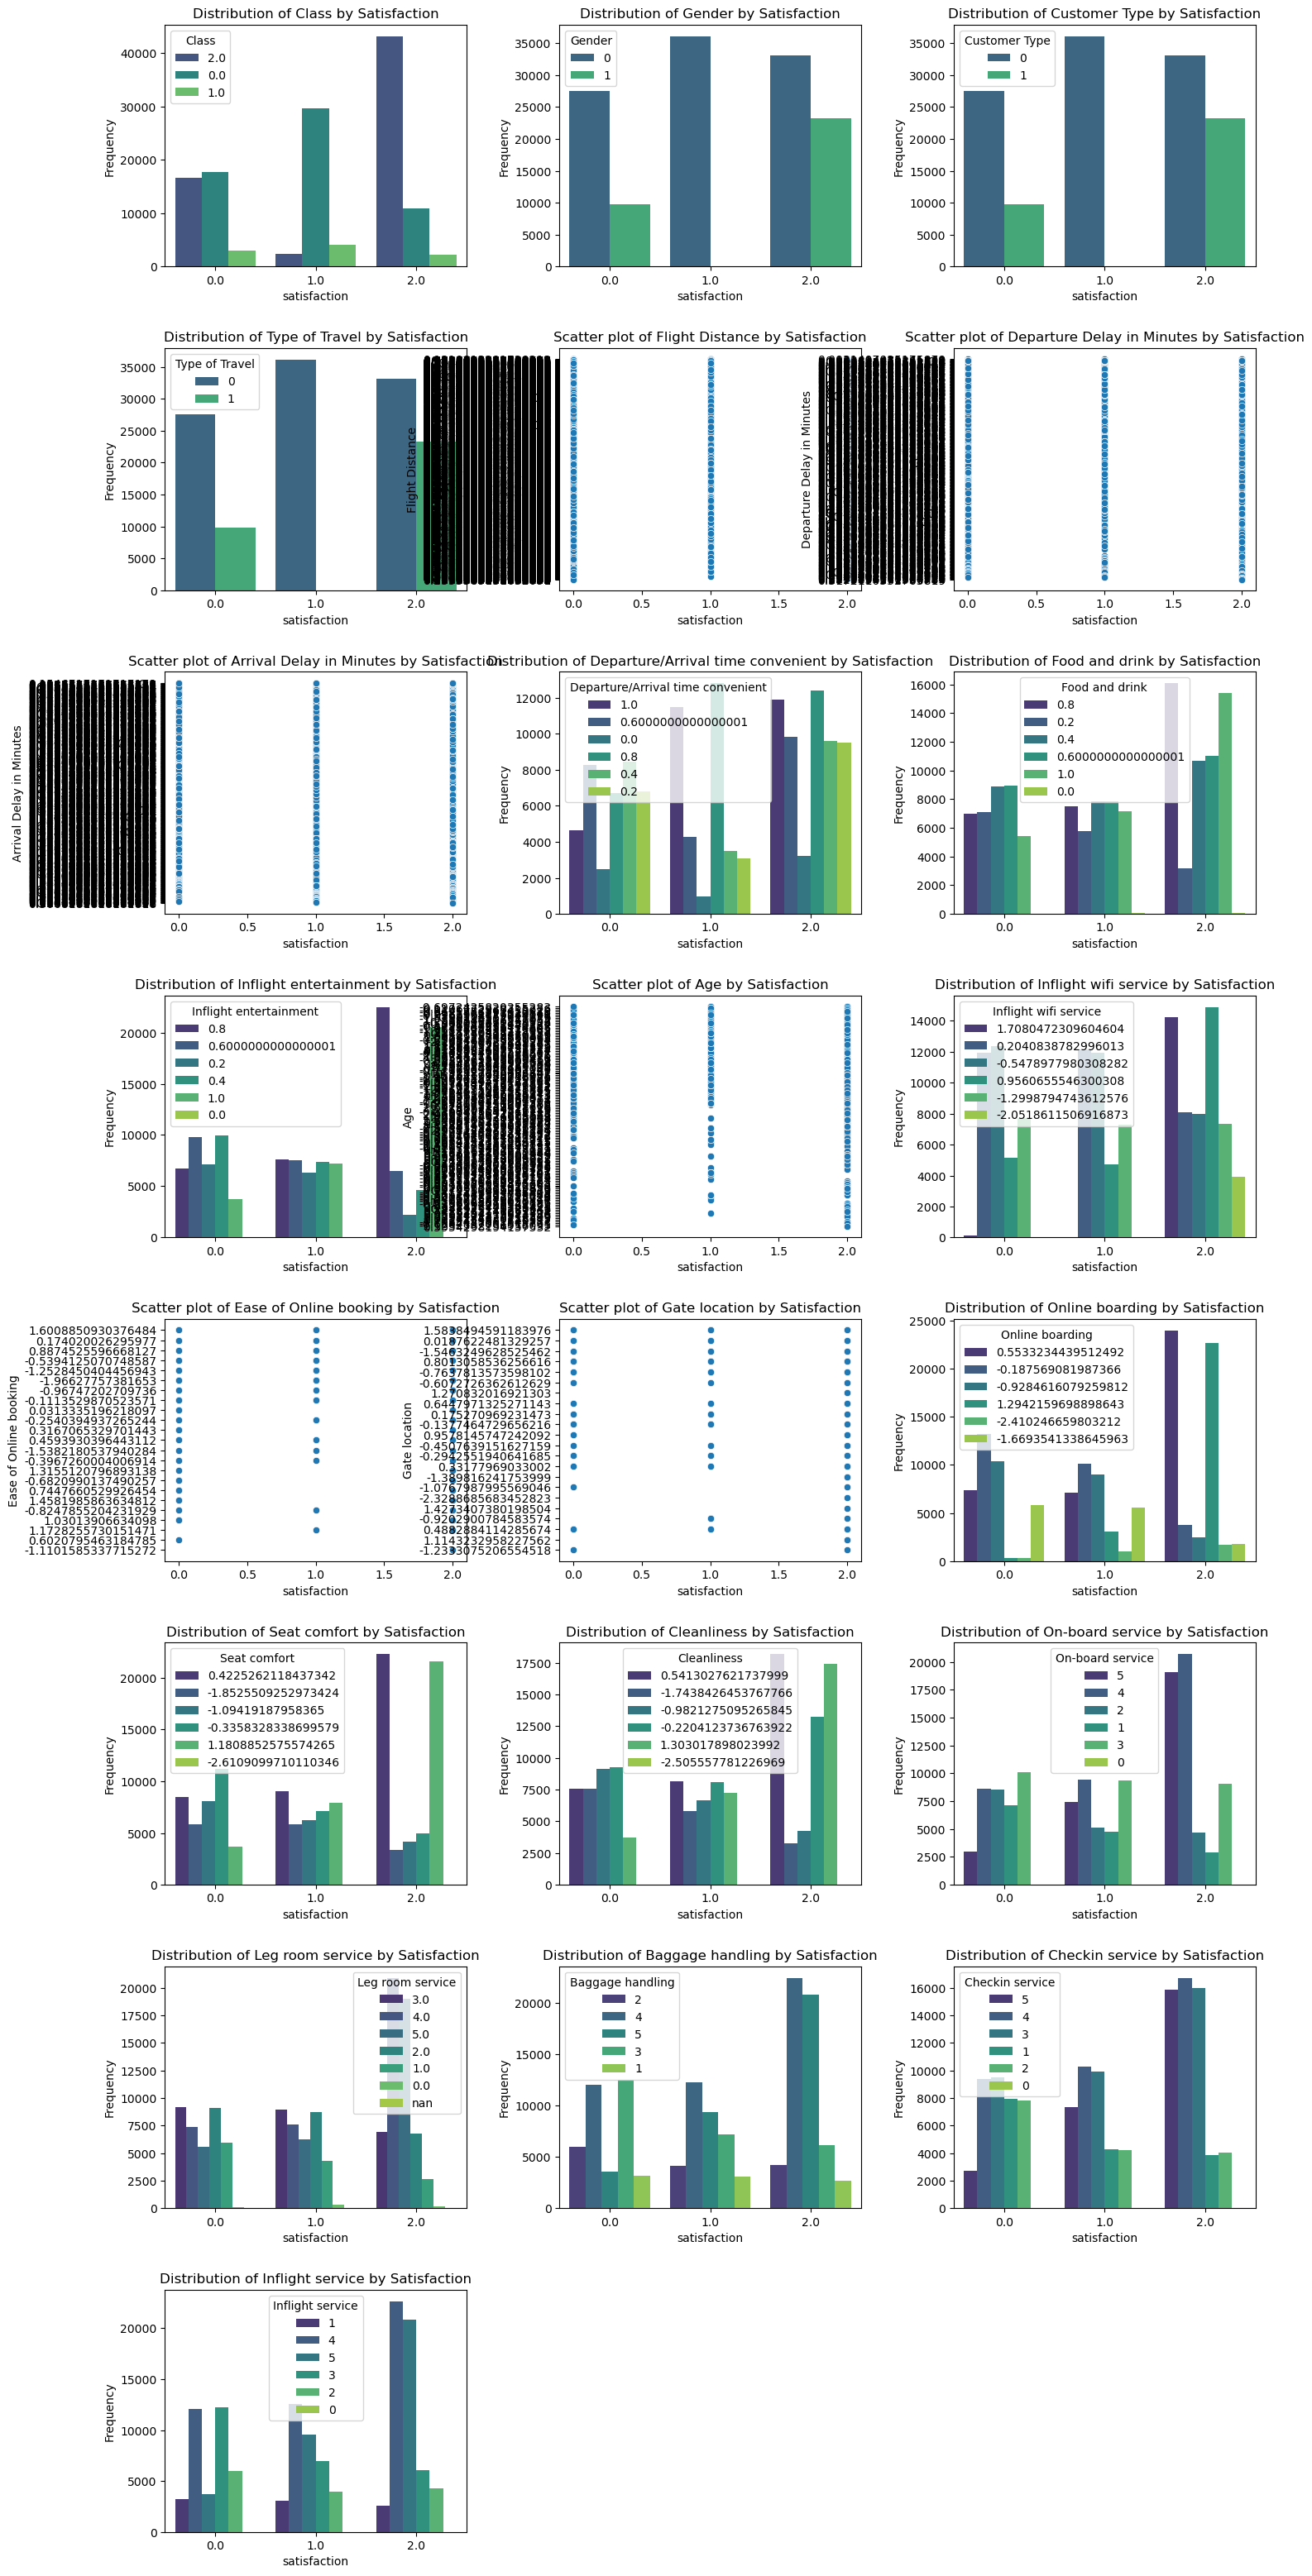

In [31]:
explicative_variables = df.columns[df.columns != 'satisfaction']
# Configuration de la grille de graphiques
n_cols = 3  # Nombre de graphiques par ligne
n_rows = (len(explicative_variables) + 2) // n_cols  # Calculer le nombre de lignes nécessaires

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))
fig.tight_layout(pad=5.0)  # Ajuster l'espacement entre les graphiques

# Création des graphiques
for i, var in enumerate(explicative_variables):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    # Convertir la variable en string si c'est numérique
    if df[var].dtype != 'object':
        df[var] = df[var].astype(str)
    if len(df[var].unique()) < 10:
        # Utilisation de countplot pour les données catégorielles
        sns.countplot(ax=ax, data=df, x='satisfaction', hue=var, palette='viridis')
        ax.set_title(f'Distribution of {var} by Satisfaction')
        ax.set_ylabel('Frequency')
    else:
        # Utilisation de scatterplot pour les données numériques
        sns.scatterplot(ax=ax, data=df, x='satisfaction', y=var)
        ax.set_title(f'Scatter plot of {var} by Satisfaction')

# Cacher les graphiques vides s'il y en a
for j in range(i + 1, n_rows * n_cols):
    if j // n_cols < n_rows and j % n_cols < n_cols:
        axes[j // n_cols][j % n_cols].axis('off')

plt.show()

Interprétation?

### 3.  Appliquer les différents algorithmes étudiés en cours. Pour chacun d'eux on procèdera ainsi : définition d'un dictionnaire d'hyperparamètres, recherche exhaustive (ou aléatoire) des meilleurs hyperparamètres, établissement de la matrice de confusion, calculs des différentes métriques (exactitude, précision, rappel, F1 score, auc, etc.). -> Classification multi

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


models_dict = [{"type": KNeighborsClassifier(), "hyperparameters" : []}]

for model in models_dict:
  classifier = model["type"]
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  print(accuracy_score(y_pred, y_test))

ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values